## **Import Packages**

In [1]:
%config Completer.use_jedi = False
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio.v2 as imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, array_to_img, plot_model
from keras.callbacks import EarlyStopping

import warnings
warnings.simplefilter("ignore", UserWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Avoid OOM errors by setting memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
directory = r'../input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

### Image Size Variations

In [4]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 623': 31,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


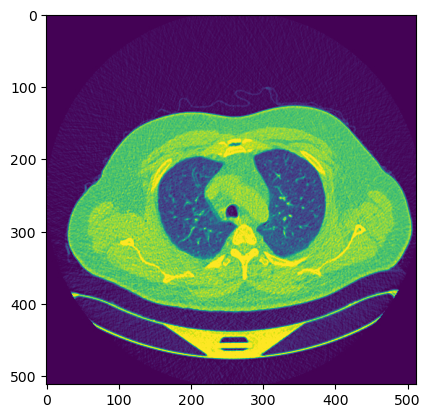

Malignant cases


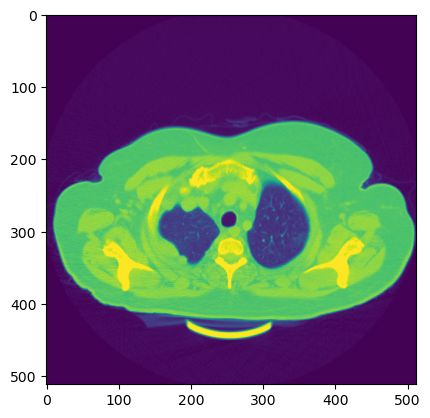

Normal cases


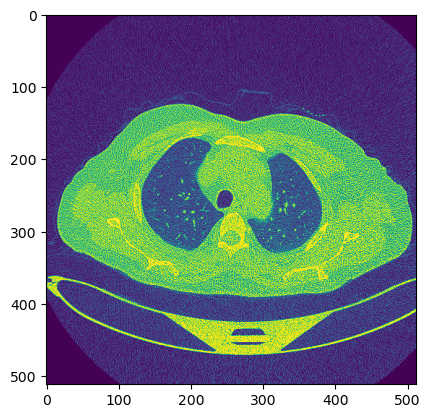

In [5]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

### Image Preprocessing and Testing

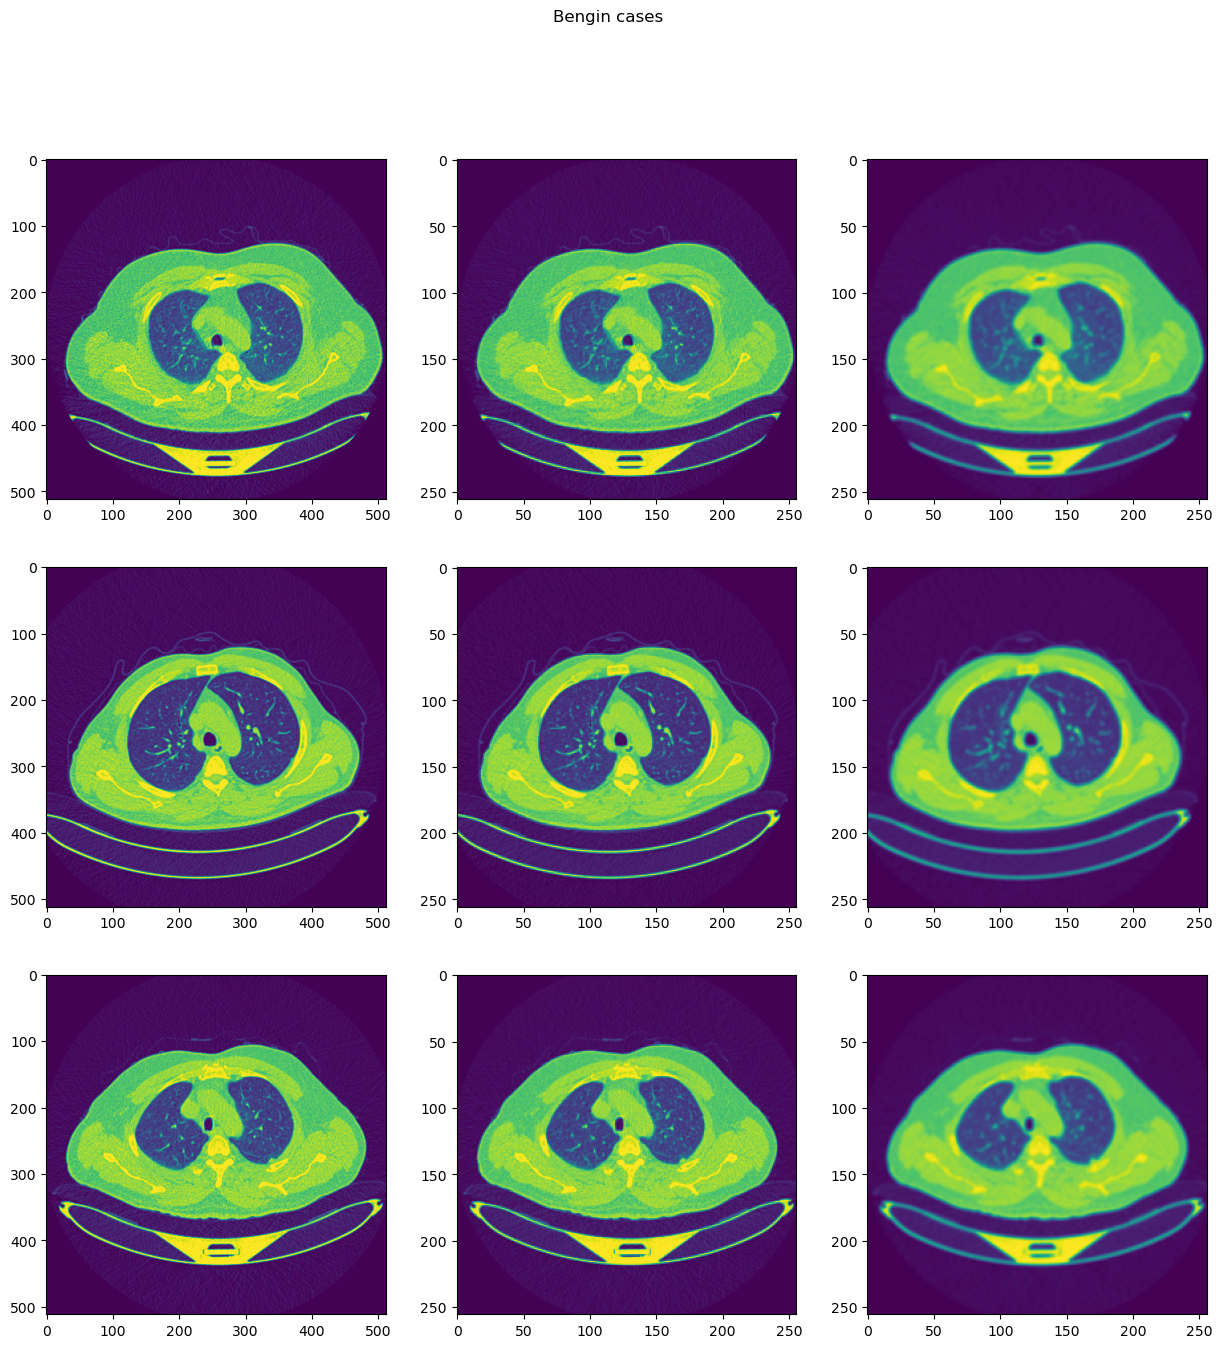

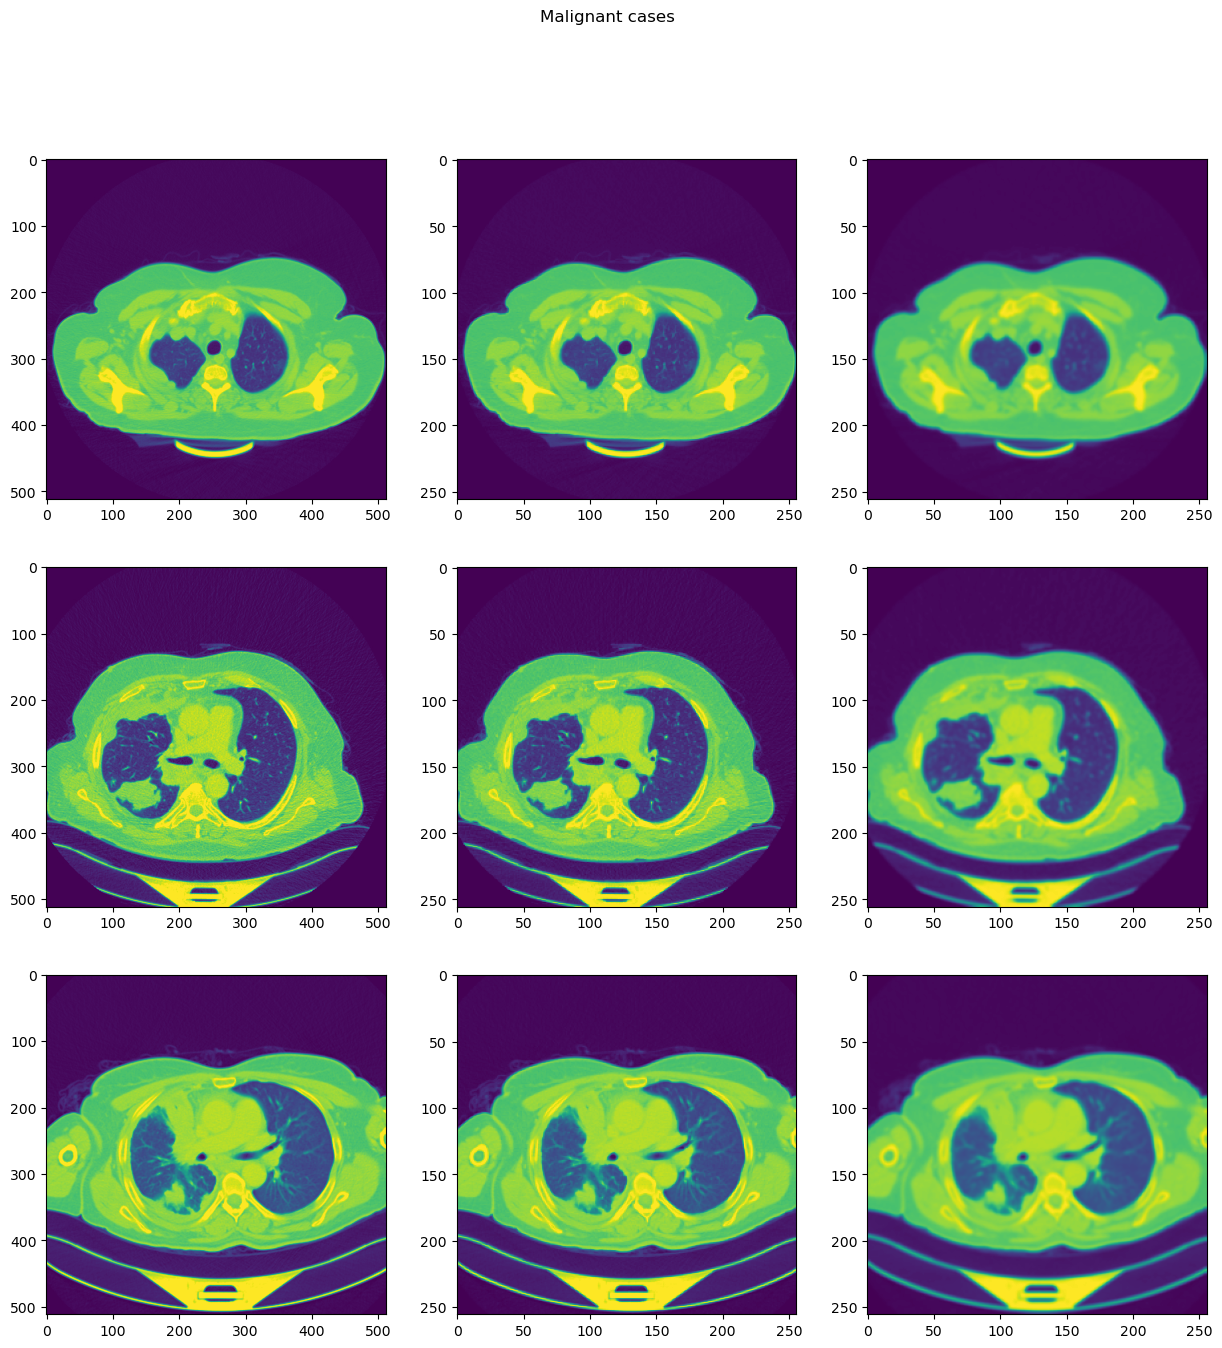

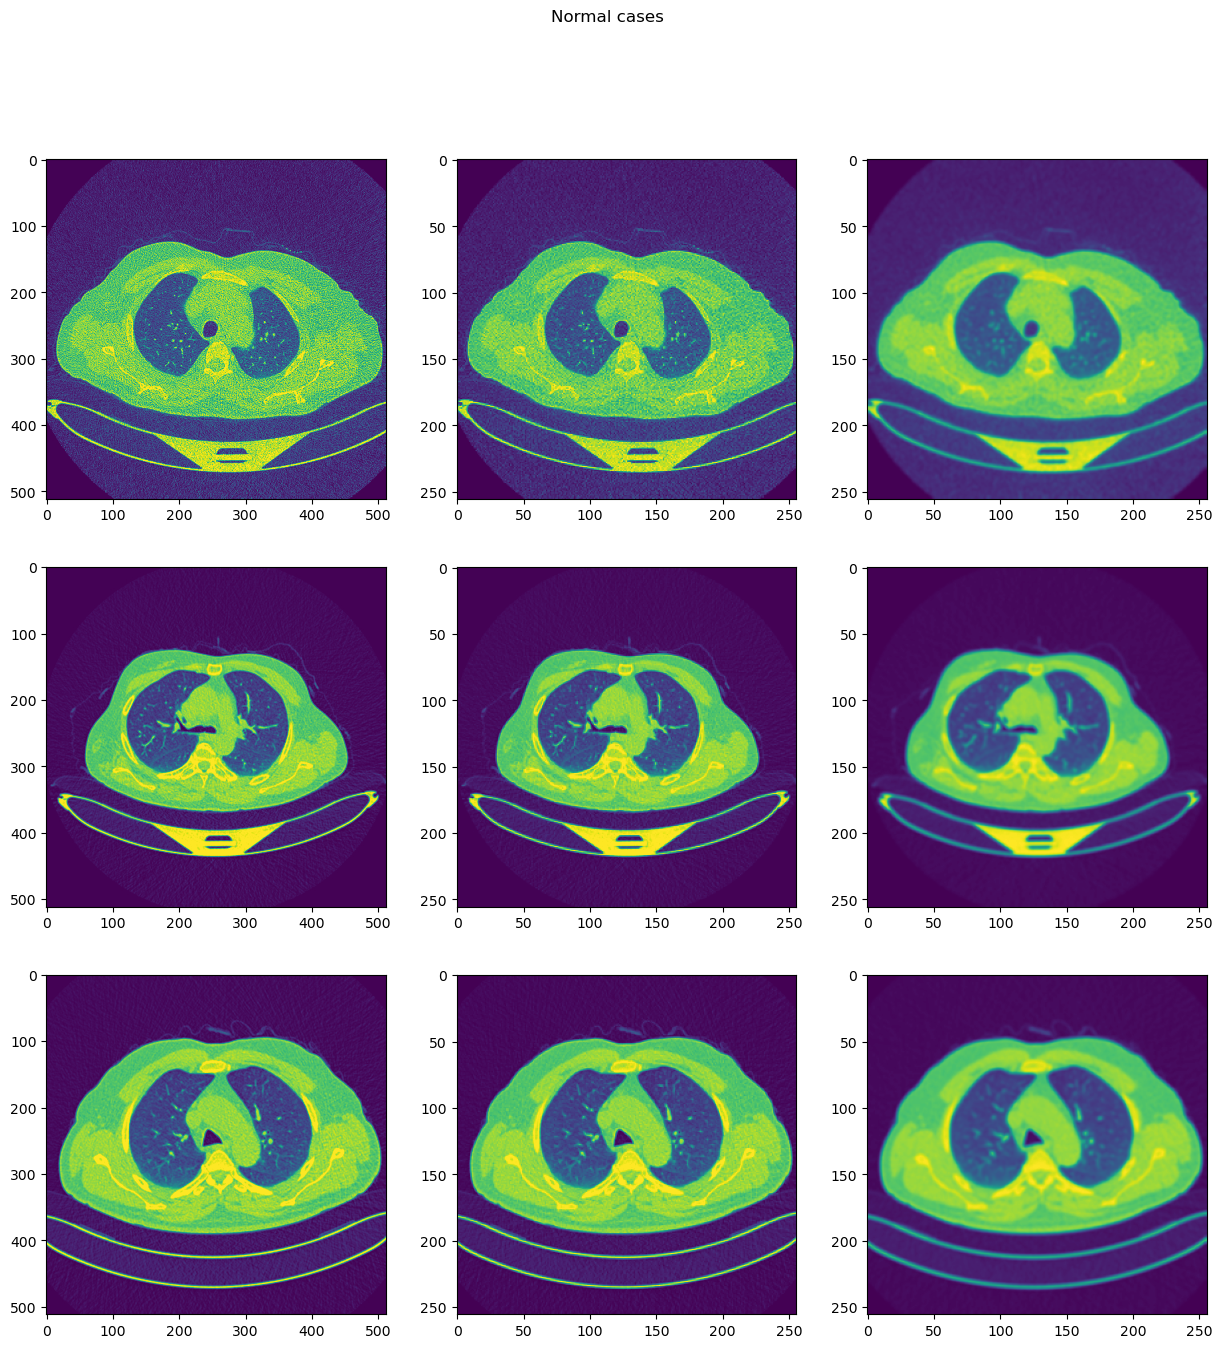

In [6]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

## **Preparing Data**

In [7]:
data = []
img_size = 256


for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=10)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 822 (822, 256, 256, 1)
Test length: 275 (275, 256, 256, 1)


### **Applying SMOTE to oversample the data**

In [9]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 430, 2: 307, 0: 85}) Counter({1: 131, 2: 109, 0: 35})


In [10]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [11]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 430, 2: 307, 0: 85})
After SMOTE: Counter({0: 430, 2: 430, 1: 430})


In [12]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1290 (1290, 256, 256, 1)


In [13]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

In [14]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8, shuffle=True)
validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=8, shuffle=True)

## **Model Building**

In [15]:
# Load the pre-trained ResNet50 model without the top classification layer
resnet_base = ResNet50(weights=None, include_top=False, input_shape=X_train.shape[1:])

# Freeze the pre-trained layers so they are not updated during training
for layer in resnet_base.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the ResNet50 base model
model.add(resnet_base)
model.add(ResNet5)

# Added custom classification layers on top
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23581440  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 40,359,171
Trainable params: 16,777,731
Non-trainable params: 23,581,440
_________________________________________________________________


In [16]:
# simple early stopping
callback = EarlyStopping(monitor='val_loss', patience=3)

In [17]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])

Epoch 1/20
103/103 [==============================] - 99s 937ms/step - loss: 0.9782 - accuracy: 0.5925 - val_loss: 0.8119 - val_accuracy: 0.6000
Epoch 2/20
103/103 [==============================] - 96s 929ms/step - loss: 0.6430 - accuracy: 0.7518 - val_loss: 0.6376 - val_accuracy: 0.7309
Epoch 3/20
103/103 [==============================] - 96s 930ms/step - loss: 0.5045 - accuracy: 0.7822 - val_loss: 0.4156 - val_accuracy: 0.8545
Epoch 4/20
103/103 [==============================] - 96s 932ms/step - loss: 0.4177 - accuracy: 0.8491 - val_loss: 0.4507 - val_accuracy: 0.8182
Epoch 5/20
103/103 [==============================] - 96s 936ms/step - loss: 0.3137 - accuracy: 0.8893 - val_loss: 0.4564 - val_accuracy: 0.7745
Epoch 6/20
103/103 [==============================] - 96s 939ms/step - loss: 0.2989 - accuracy: 0.8832 - val_loss: 0.3725 - val_accuracy: 0.8545
Epoch 7/20
103/103 [==============================] - 96s 934ms/step - loss: 0.3868 - accuracy: 0.8382 - val_loss: 0.2552 - val_ac

In [19]:
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 23s 2s/step
              precision    recall  f1-score   support

           0       1.00      0.57      0.73        35
           1       0.98      1.00      0.99       131
           2       0.89      0.99      0.94       109

    accuracy                           0.94       275
   macro avg       0.96      0.85      0.88       275
weighted avg       0.95      0.94      0.94       275

[[ 20   1  14]
 [  0 131   0]
 [  0   1 108]]


## **Results**

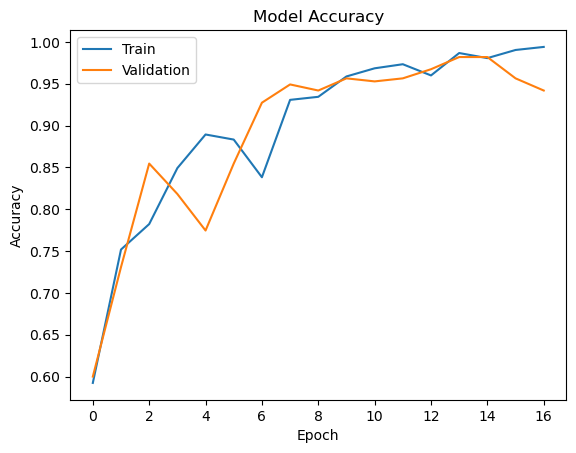

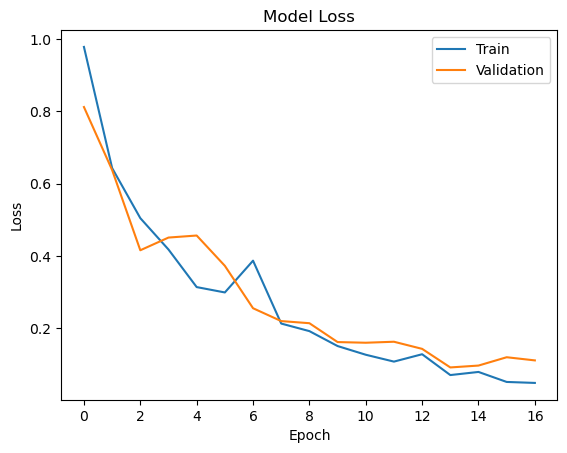

In [20]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()